# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [618]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


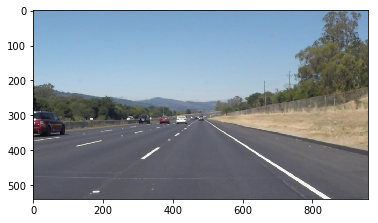

In [619]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [620]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            print(x1,y1,x2,y2)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [705]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

In [706]:
def display_image(image, img_file, show_gray=False): 
    fig = plt.figure()
    fig.suptitle(img_file, fontsize=20)
    #printing out some stats and plotting
    
    if show_gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

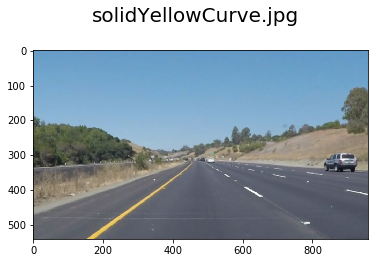

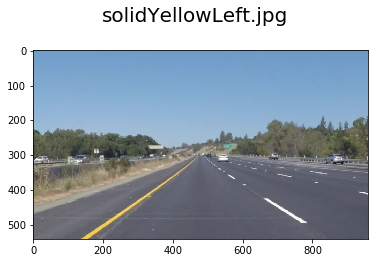

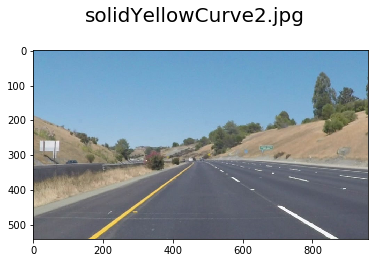

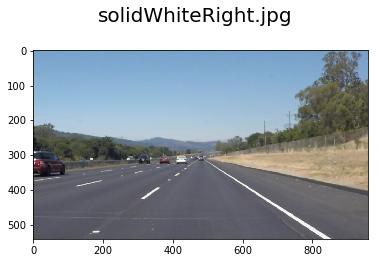

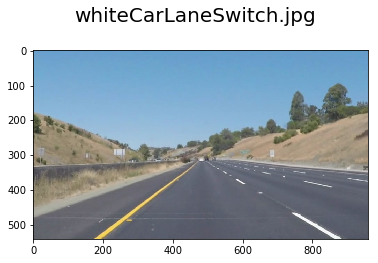

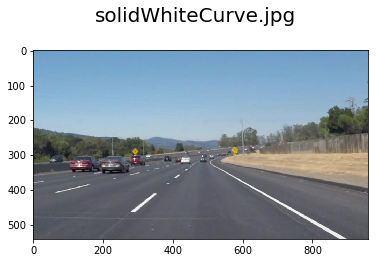

In [707]:
test_img_dir = "test_images"
for test_img_file in os.listdir(test_img_dir):
    image = mpimg.imread('%s/%s' % (test_img_dir, test_img_file))
    
    display_image(image, test_img_file)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [708]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

In [709]:
def display_image2(images, img_file, 
                  show_gray_arr=None): 
    num_of_imgs = len(images)
    fig, axarr = plt.subplots(1, num_of_imgs, figsize=(20,10))
    fig.suptitle(img_file, fontsize=20)
    #printing out some stats and plotting
    
    if show_gray_arr is None:
        show_gray_arr = [True for x in range(num_of_imgs)]
    
    for i in range(num_of_imgs):
        ax=axarr[i]
        if show_gray_arr[i]:
            ax.imshow(images[i], cmap='gray')
        else:
            ax.imshow(images[i])  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
          
    plt.show()

In [895]:
def crop_roi(img):
    bottom_y = img.shape[0]
    top_y = int(0.61*img.shape[0])
    top_left_x = int(0.45*img.shape[1])
    top_right_x = int(0.55*img.shape[1])
    bottom_left_x = int(0.1*img.shape[1])
    bottom_right_x = int(0.9*img.shape[1])

    pt0 = [bottom_left_x, bottom_y]
    pt1 = [top_left_x, top_y]
    pt2 = [top_right_x, top_y]
    pt3 = [bottom_right_x, bottom_y]
    
    bounding_box = np.array([pt0, pt1, pt2, pt3], np.int32)
    
    cropped_img = region_of_interest(img, [bounding_box])   
    
    return cropped_img

In [810]:
def find_lane(image):
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    masked_edges = crop_roi(edges)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 24    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    color_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)   
    
    return lines_edges 

In [811]:
def find_lane2(image):
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    masked_edges = crop_roi(edges)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 24    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    color_edges = hough_lines2(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)   
    
    return lines_edges 

In [825]:
class Line(object):
    def __init__(self, x1,y1,x2,y2):
        self.x1,self.y1,self.x2,self.y2 = x1,y1,x2,y2
        self._m = None
        self._b = None
        
    @property
    def m(self):
        if self._m is None:
            if self.x2-self.x1 == 0:
                self._m = 0.0
            else:
                self._m = float(self.y2-self.y1)/float(self.x2-self.x1)
            
        return self._m
    
    @property
    def b(self):
        if self._b is None:
            self._b = self.y1 - self.m*self.x1
            
        return self._b
    
    def find_x(self, y):
        return (y-self.b)/self.m
    
    def find_y(self, x):
        return self.m*x + self.b

In [819]:
class LineList(object):
    def __init__(self, line_objs=[]):
        self.line_objs = line_objs
        self._mean_m = None
        self._mean_b = None
        self._top_y = None
        self._bottom_y = None
        
    @property
    def length(self):
        return len(self.line_objs)
        
    @property
    def mean_m(self):
        if self._mean_m is None:
            if self.length == 0:
                self._mean_m = 0.0
            else:
                self._mean_m = float(np.mean([lo.m for lo in self.line_objs]))
            
        return self._mean_m
    
    @property
    def mean_b(self):
        if self._mean_b is None:
            if self.length == 0:
                self._mean_b = 0.0
            else:
                self._mean_b = float(np.mean([lo.b for lo in self.line_objs]))
            
        return self._mean_b
    
    @property
    def top_y(self):
        if self._top_y is None:
            min_y = None
        
            for line_obj in self.line_objs:
                if min_y is None or line_obj.y1 < min_y:
                    min_y = line_obj.y1
                    
                if min_y is None or line_obj.y2 < min_y:
                    min_y = line_obj.y2
            
            self._min_y = int(min_y)
            
        return self._top_y
    
    @property
    def bottom_y(self):
        if self._bottom_y is None:
            max_y = 0
        
            for line_obj in self.line_objs:
                if line_obj.y1 > max_y:
                    max_y = line_obj.y1
                    
                if line_obj.y2 > max_y:
                    max_y = line_obj.y2
                
            self._bottom_y =  int(max_y)
            
        return self._bottom_y
    
    @property
    def top_y(self):
        if self._top_y is None:
            min_y = None
        
            for line_obj in self.line_objs:
                if min_y is None or line_obj.y1 < min_y:
                    min_y = line_obj.y1
                    
                if min_y is None or line_obj.y2 < min_y:
                    min_y = line_obj.y2
                
            if min_y is None:
                self._top_y = None
            else:
                self._top_y = int(min_y)
            
        return self._top_y
    
    def get_x(self, y):
        #print("###get_x", y, self.mean_b, self.mean_m)
        if self.mean_m == 0.0:
            return 0
       
        return int((y - self.mean_b)/self.mean_m)

    def get_best_xy_pairs_from_y(self, bottom_y):
        if self.top_y is None:
            top_y = bottom_y
        else:
            top_y = self.top_y 
            
        top_x = self.get_x(top_y)
            
        bottom_x = self.get_x(bottom_y)
        return (top_x, top_y, bottom_x, bottom_y)

In [871]:
def draw_lines2(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    line_objs = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            curr_line_obj = Line(x1,y1,x2,y2)
            line_objs.append(curr_line_obj)
    
    left_line_objs = []
    right_line_objs = []
    for line_obj in line_objs:
        print("###line_obj.m", line_obj.m)
        if line_obj.m > 0.0:  
            left_line_objs.append(line_obj)
        else:
            right_line_objs.append(line_obj)
            
    left_line_list = LineList(left_line_objs)
    right_line_list = LineList(right_line_objs)
    
    print("###left_line_list.length", left_line_list.length)
    print("###right_line_list.length", right_line_list.length)
    
    bottom_y = img.shape[0]
    
    mean_lines = [left_line_list.get_best_xy_pairs_from_y(bottom_y), 
                  right_line_list.get_best_xy_pairs_from_y(bottom_y)]

    for x1,y1,x2,y2 in mean_lines:
        cv2.line(img, (x1, y1), (x2,y2), color, thickness)

def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines2(line_img, lines, thickness=8)
    return line_img

###line_obj.m -0.7554744525547445
###line_obj.m -0.7019867549668874
###line_obj.m -0.754601226993865
###line_obj.m -0.7016949152542373
###line_obj.m 0.6046511627906976
###line_obj.m 0.5986842105263158
###line_obj.m 0.5454545454545454
###line_obj.m 0.6214285714285714
###line_obj.m -0.7473684210526316
###line_obj.m 0.6363636363636364
###line_obj.m 0.6025641025641025
###line_obj.m 0.5987261146496815
###line_obj.m -0.8666666666666667
###line_obj.m 0.6258992805755396
###left_line_list.length 8
###right_line_list.length 6
lane1: (540, 960, 3) uint8
0 204


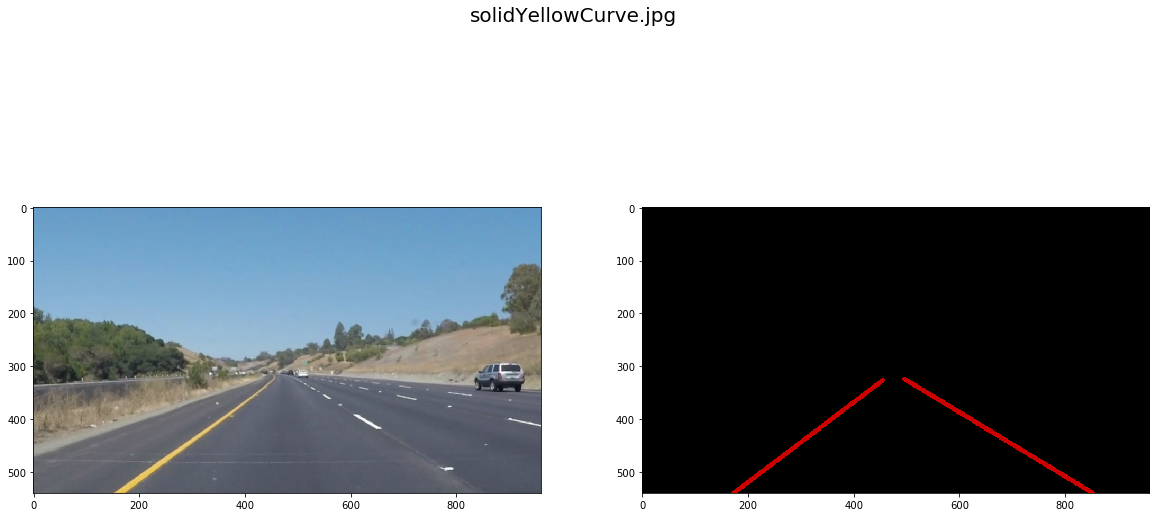

###line_obj.m -0.7276785714285714
###line_obj.m -0.6765676567656765
###line_obj.m 0.604
###line_obj.m 0.6479591836734694
###line_obj.m -0.7288135593220338
###line_obj.m 0.6497890295358649
###line_obj.m -0.7192982456140351
###line_obj.m 0.6031746031746031
###line_obj.m -0.7272727272727273
###line_obj.m -0.7263157894736842
###line_obj.m 0.6466666666666666
###line_obj.m -0.6754385964912281
###left_line_list.length 5
###right_line_list.length 7
lane1: (540, 960, 3) uint8
0 204


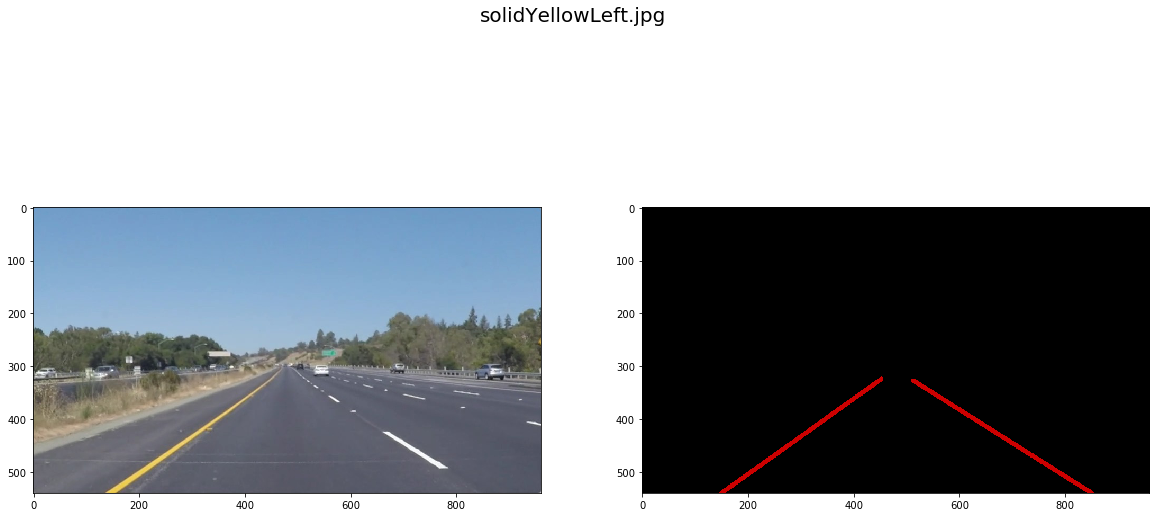

###line_obj.m -0.7263513513513513
###line_obj.m -0.7553956834532374
###line_obj.m -0.7543103448275862
###line_obj.m -0.726027397260274
###line_obj.m 0.5986842105263158
###line_obj.m 0.5776173285198556
###line_obj.m 0.599009900990099
###line_obj.m -0.7192982456140351
###line_obj.m 0.5769230769230769
###line_obj.m 0.5755395683453237
###line_obj.m -0.7264150943396226
###left_line_list.length 5
###right_line_list.length 6
lane1: (540, 960, 3) uint8
0 204


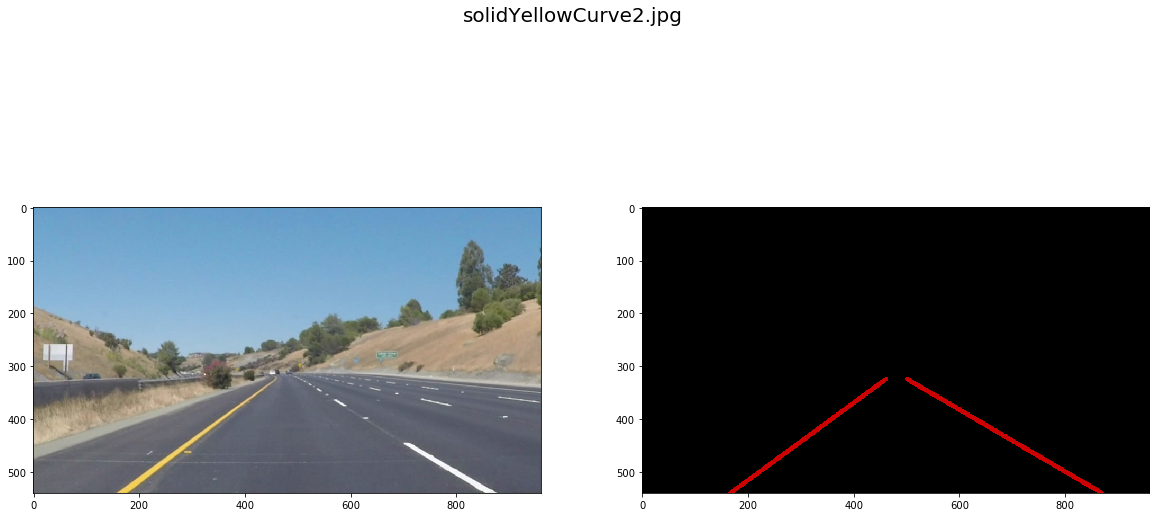

###line_obj.m 0.651685393258427
###line_obj.m 0.6272189349112426
###line_obj.m 0.6519337016574586
###line_obj.m -0.6950354609929078
###line_obj.m -0.7246376811594203
###line_obj.m 0.6239067055393586
###line_obj.m -0.7246376811594203
###line_obj.m 0.6515151515151515
###line_obj.m -0.6976744186046512
###line_obj.m -0.704225352112676
###line_obj.m 0.65625
###left_line_list.length 6
###right_line_list.length 5
lane1: (540, 960, 3) uint8
0 204


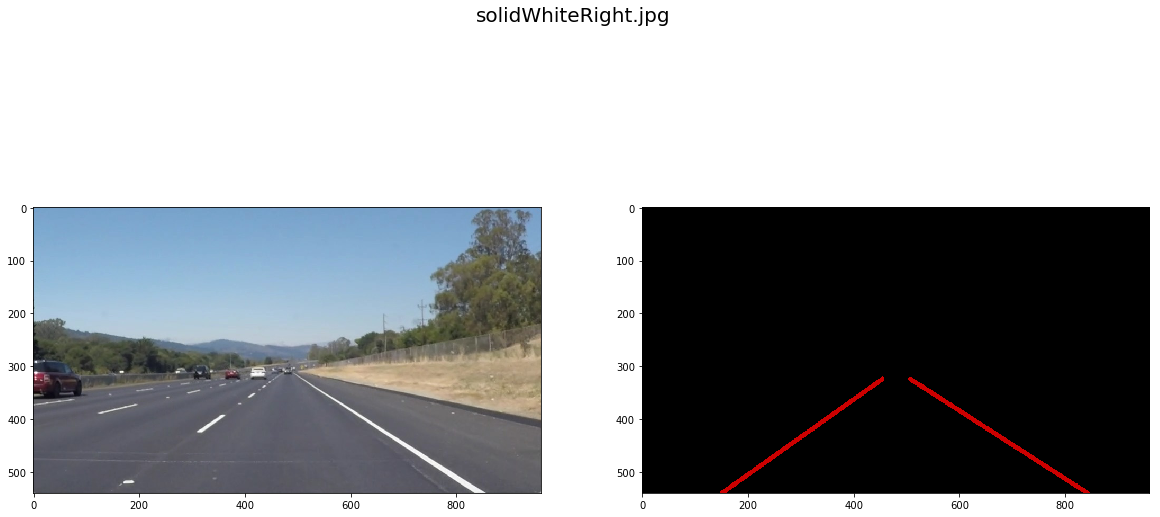

###line_obj.m -0.781021897810219
###line_obj.m -0.7320261437908496
###line_obj.m -0.7827715355805244
###line_obj.m 0.5988857938718662
###line_obj.m -0.7305699481865285
###line_obj.m 0.6022727272727273
###line_obj.m -0.7272727272727273
###line_obj.m 0.5743243243243243
###line_obj.m -0.34615384615384615
###line_obj.m -0.7043010752688172
###line_obj.m 0.5974025974025974
###left_line_list.length 4
###right_line_list.length 7
lane1: (540, 960, 3) uint8
0 204


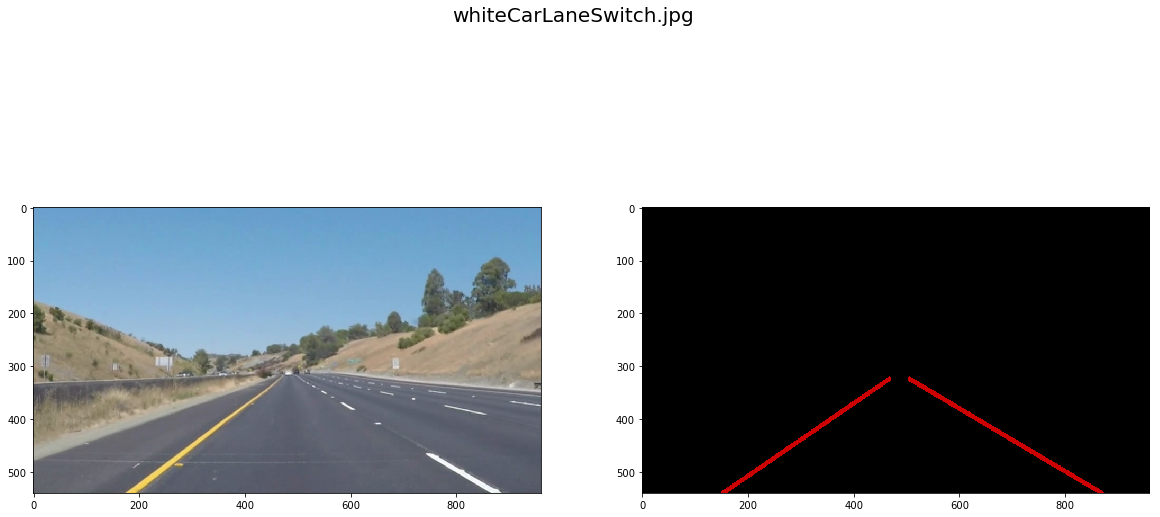

###line_obj.m 0.5764192139737991
###line_obj.m 0.5555555555555556
###line_obj.m -0.8367346938775511
###line_obj.m -0.8125
###line_obj.m -0.8385093167701864
###line_obj.m 0.5564516129032258
###line_obj.m -0.7300613496932515
###line_obj.m -0.8405797101449275
###left_line_list.length 3
###right_line_list.length 5
lane1: (540, 960, 3) uint8
0 204


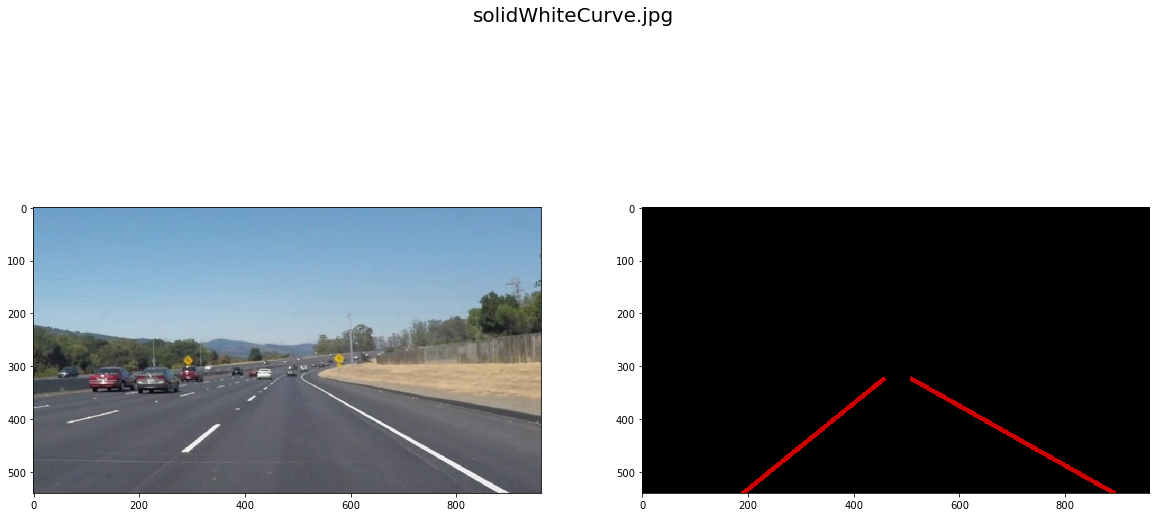

In [872]:
test_img_dir = "test_images"
for test_img_file in os.listdir(test_img_dir):
    image = mpimg.imread('%s/%s' % (test_img_dir, test_img_file))
    lane1 = find_lane2(image)
    print("lane1:", lane1.shape, lane1.dtype)
    print(np.min(lane1), np.max(lane1))

    images = [image, lane1]
    show_gray_arr = [False, True]    
    """
    images = [image]
    show_gray_arr = [False]
    """
    
    display_image2(images, test_img_file, show_gray_arr)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [593]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [782]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = weighted_img(find_lane(image), image)
    return result

In [783]:
def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = weighted_img(find_lane2(image), image)
    return result

Let's try the one with the solid white lane on the right first ...

In [784]:
!mkdir test_videos_output

mkdir: test_videos_output: File exists


In [785]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

514 324 817 520
187 513 427 339
520 327 714 444
552 352 606 384
202 514 453 325
513 324 770 479
205 513 279 457
187 512 415 347
507 324 587 372
199 515 450 326
695 442 848 538
187 514 446 326
728 454 768 478
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|          | 2/222 [00:00<00:11, 18.88it/s]

514 324 817 520
187 513 427 339
520 327 714 444
552 352 606 384
202 514 453 325
513 324 770 479
205 513 279 457
187 512 415 347
507 324 587 372
199 515 450 326
695 442 848 538
187 514 446 326
728 454 768 478
513 324 778 484
507 324 737 468
170 538 450 327
151 538 349 395
721 459 845 537
508 324 700 444
514 324 748 465
170 539 455 324
348 396 451 324
736 459 803 500
279 455 450 326
797 508 846 538
164 528 433 339
516 325 846 539
508 324 676 421
170 538 452 325
151 538 249 467
666 416 739 459
507 324 604 383
171 539 260 471
542 346 626 397
336 404 450 324
605 385 750 466
535 336 671 427
572 359 712 453
509 325 618 386
153 537 456 324
514 324 745 463
517 327 781 486
507 324 766 486
710 452 847 538
177 533 408 353
148 538 211 494
509 324 686 435
169 538 225 495
322 414 449 325
324 417 456 324
333 416 450 325
513 324 767 477
150 537 213 494
707

  4%|▎         | 8/222 [00:00<00:10, 20.96it/s]

 450 769 488
508 324 738 468
513 324 764 475
717 456 848 538
311 429 456 324
302 428 449 325
148 538 157 532
507 324 849 538
515 324 728 452
519 328 781 486
314 429 451 326
508 324 748 474
517 326 767 477
684 435 848 538
283 441 449 325
290 443 454 324
514 328 790 501
292 443 454 325
515 324 736 457
786 500 848 539
511 326 846 536
514 324 753 468
510 325 790 500
515 324 728 452
250 463 446 326
797 506 848 538
269 462 450 326
254 461 449 325
267 462 440 332
509 324 563 357
510 325 851 538
514 324 753 468
515 324 728 452
326 410 448 325
571 359 661 413
233 488 450 324
230 488 453 326
214 490 223 484
326 411 455 324
509 324 845 534
585 373 849 538
514 324 764 475
509 324 592 376
316 425 455 324
310 423 452 324
309 422 449 324
314 425 454 324
557 355 604 384
559 352 767 477
511 326 779 494
163 524 188 524
617 396 844 538
518 329 823 513
571 366 773 493
507 325 610 390
303 438 452 326
289 439 450 326
297 441 456 325
515 327 566 357
507 324 714 448
306 426 451 324
504 324 764 492
557 355 859

  5%|▌         | 12/222 [00:00<00:09, 23.21it/s]

504 325 834 539
507 324 733 465
501 324 782 506
230 483 456 324
239 485 461 324
709 449 821 518
240 485 462 324
231 481 455 324
787 496 856 539
764 493 834 538
517 331 682 434
237 485 458 325
502 324 833 539
515 329 762 483
514 332 828 536
509 324 825 521
183 514 454 324
195 516 460 324
183 513 450 326
745 471 855 539
504 324 622 401
196 516 291 447
194 516 458 324
511 324 855 539
527 335 796 503
145 538 451 324
512 329 833 538
164 538 413 351
506 324 633 407
194 517 450 325
266 462 456 324
512 324 560 354
646 417 833 539
800 504 855 538
682 441 802 519
144 538 448 325
513 324 

  7%|▋         | 15/222 [00:00<00:09, 22.92it/s]

857 539
649 417 835 538
508 324 645 413
162 538 425 340
142 538 448 324
590 373 811 511
142 539 447 325
162 539 421 344
514 324 634 399
607 389 649 416
380 377 444 332
509 325 696 447
523 329 859 539
538 341 738 475
516 324 859 538
703 451 836 538
138 538 207 490
158 538 222 492
321 412 446 324
157 538 221 491
138 539 212 489
510 324 664 424
327 412 452 324
328 412 442 332
667 426 810 522
324 413 451 324
517 324 859 538
518 329 766 491
512 324 655 

  8%|▊         | 18/222 [00:00<00:08, 23.94it/s]

417
690 442 837 538
518 324 722 452
304 423 440 328
608 382 859 539
312 424 450 324
764 491 837 539
304 422 439 328
305 424 427 342
646 412 688 439
517 324 683 428
516 328 747 479
516 324 858 538
721 463 836 538
511 324 666 425
289 439 450 326
282 437 447 326
532 335 857 538
400 356 447 324
673 431 797 512
294 439 452 324
283 438 446 324
514 324 856 538
508 324 750 482
686 441 834 538
509 324 661 423
268 459 455 324
339 399 450 325
267 459 449 327
256 459 447 325
533 337 855 539
512 324 854 538
507 324 693 445
519 333 832 537
707 456 833 538
325 410 448 327
228 486 440 337
326 410 453 325
506 324 761 490
226 486 449 330
229 486 371 387


  9%|▉         | 21/222 [00:00<00:07, 25.45it/s]

511 324 853 538
505 324 790 510
648 418 832 538
524 333 853 539
506 324 693 446
317 419 453 324
319 425 458 324
310 422 329 409
310 423 452 324
310 425 448 328
742 480 832 539
324 422 459 324
510 324 854 538
505 324 757 488
666 430 832 538
519 330 854 539
300 439 457 325
289 437 456 325
290 438 458 324
683 441 749 483
301 438 453 324
645 416 703 453
511 324 854 538
520 330 853 538
526 338 833 538
505 324 679 437
277 456 452 324
264 456 459 324
264 454 457 324
301 439 454 324
279 455 437 340
530 336 854 539
506 324 785 506
687 443 833 538
243 479 457 324
512 324 854 538
232 477 451 324
507 324 656 421
246 478 436 340
232 479 446 329
232 476 314 419
513 

 12%|█▏        | 26/222 [00:00<00:06, 29.08it/s]

324 855 538
535 339 855 539
526 337 833 537
197 499 456 324
508 324 672 431
201 510 454 326
186 507 434 340
733 473 834 539
507 324 717 461
305 429 450 324
263 466 450 325
520 329 854 538
513 324 853 537
507 324 743 478
162 538 454 326
661 425 832 537
148 535 450 324
738 476 833 538
141 539 271 448
163 539 432 343
508 324 666 427
537 340 854 538
279 445 453 324
212 491 451 324
354 398 456 324
520 329 854 538
507 324 748 481
149 535 451 324
536 344 829 535
164 538 432 343
513 324 849 534
180 514 450 325
142 539 240 470
753 486 833 538
218 500 444 330
255 465 456 324
516 326 855 538
507 324 772 497
668 430 834 538
508 324 672 431
165 539 225 493
147 536 210 492
324 415 452 325
330 416 457 324
535 339 855 539
188 522 226 494
324 413 450 325
538 341 855 539
529 339 834 538
513 324 856 538
307 426 451 325
319 427 456 324
806 521 833 539
508 324 531 339
164 538 175 530
508 325 740 476
528 334 854 538
788 509 832 537
307 425 450 325
316 428 454 324
514 324 856 538
537 344 835 538
508 324 689 

 15%|█▍        | 33/222 [00:01<00:08, 22.14it/s]

531 335 857 539
553 354 836 538
513 327 798 513
516 325 857 538
259 458 449 325
510 324 607 384
270 459 454 325
727 468 834 538
259 456 453 325
547 346 760 479
271 459 422 349
509 324 768 493
519 327 858 539
540 345 837 538
241 483 449 327
216 487 448 325
218 487 449 326
546 345 719 453
350 402 454 324
678 426 858 538
521 328 858 539
515 328 823 529
564 361 836 538
311 421 455 324
325 420 447 325
311 420 454 324
516 324 535 336
509 324 589 376
510 324 633 400
321 422 435 333
765 480 858 538
525 331 858 539
557 357 836 538
508 324 837 538
549 347 794 500
690 434 857 538
292 435 450 324
301 437 416 353
509 324 555 354
514 324 551 347
531 336 855 539
562 361 834 538
508 325 815 525
508 324 700 443
267 453 451 324
279 455 452 325
740 466 856 538
507 324 536 342
381 380 456 324
513 324 557 352
619 399 834 539
274 449 447 328


 18%|█▊        | 40/222 [00:01<00:06, 26.63it/s]

554 352 817 516
513 325 854 538
555 357 833 538
248 478 404 364
235 476 452 324
784 494 855 538
506 324 541 346
419 346 451 324
246 478 455 326
249 467 454 324
548 352 590 379
512 324 540 341
509 325 713 452
244 478 456 324
236 475 313 421
509 325 781 494
552 355 833 538
513 325 587 372
192 507 453 324
209 508 445 330
191 508 453 325
506 324 599 385
752 475 807 510
785 495 848 535
512 324 552 349
274 460 451 327
192 506 289 438
507 324 598 379
592 382 833 539
829 522 855 539
207 509 305 430
555 352 854 539
605 390 833 539
147 538 453 324
569 366 833 538
167 538 359 398
167 537 404 364
146 538 275 448
506 324 651 419
508 324 792 501
512 324 569 360
671 434 828 536
357 398 453 326
511 327 561 359
543 344 854 538
561 355 854 538
582 374 832 537
166 539 451 324
642 414 833 538
144 538 400 365
557 357 676 435
509 324 556 355
513 324 564 356
197 516 453 324
519 330 854 539
145 538 401 365
166 538 450 324
257 464 441 330
145 539 256 464
553 354 587 376
346 406 455 324
510 324 854 539
641 413 

 20%|█▉        | 44/222 [00:01<00:06, 28.78it/s]

513 325 785 508
516 324 677 428
537 340 833 539
716 451 822 519
518 324 747 472
794 500 855 539
336 402 420 347
242 481 450 324
222 483 449 324
511 324 854 538
510 324 733 474
522 331 831 539
314 419 434 332
517 324 547 343
518 326 616 388
322 420 449 325
313 418 447 324
737 475 831 538
675 427 853 539
175 518 188 509
332 414 438 332
527 334 832 539
599 378 855 538
512 325 740 478
712 458 830 537
305 434 444 325
515 324 612 385
295 432 410 349
333 413 446 325
295 433 433 333
510 324 615 387
518 325 550 345
529 335 832 539
595 375 855 538
515 324 622 391
511 324 715 461
281 450 446 326
654 413 855 539
270 448 446 325
270 450 408 350
750 483 833 538


 23%|██▎       | 51/222 [00:02<00:06, 25.42it/s]

510 324 750 485
542 344 831 539
518 325 718 454
746 470 853 539
240 469 448 324
589 370 764 483
515 324 658 416
254 471 446 326
251 472 433 335
736 474 832 538
241 468 443 326
738 465 782 494
240 470 407 353
516 328 772 500
513 324 831 538
628 397 853 538
197 499 448 324
514 324 624 393
213 501 444 327
215 500 447 325
523 330 682 430
700 443 853 539
198 498 442 327
197 501 415 348
532 338 831 539
524 333 830 539
535 336 755 478
141 538 447 324
163 536 292 442
517 325 664 420
737 465 843 533
671 423 803 508
161 538 265 462
546 347 830 538
140 538 439 329
214 498 292 441
288 439 452 324
509 324 713 461
799 504 853 539
810 524 831 538
587 371 853 538
535 340 831 539
139 539 447 324
513 324 717 452
160 538 266 461
509 324 536 341
514 324 648 408
699 442 852 538
261 458 451 325
192 501 452 325
254 468 449 326
160 539 426 339
724 468 831 538
508 324 643 412
546 347 831 539
662 418 853 538
569 359 760 479
322 412 453 324
515 324 641 403
158 539 422 340
137 539 218 482
718 454 852 538
137 538 

 26%|██▌       | 57/222 [00:02<00:06, 24.56it/s]

526 335 775 502
513 324 739 466
559 356 831 539
729 461 852 538
291 437 452 325
281 437 448 324
601 380 853 538
514 324 597 376
289 437 449 325
281 436 447 324
510 325 597 383
512 324 831 539
525 332 847 534
516 329 642 413
265 455 453 324
635 402 852 538
253 455 447 324
513 324 738 465
254 454 445 325
540 344 790 512
514 324 597 376
264 455 446 328
507 324 536 343
511 324 851 537
505 324 720 464
615 396 783 506
704 455 829 537
232 480 455 324
612 388 852 538
218 481 450 324
512 324 758 478
322 409 449 324
230 480 452 324
520 333 586 375
514 327 851 538
504 324 746 482
633 409 829 537
510 324 814 514
306 421 450 324
313 423 455 324
505 324 619 398
316 422 456 324
798 518 829 539
334 403 451 325
780 506 830 538
508 324 850 538
511 330 773 501
687 446 828 538
286 435 451 324
292 438 453 326
513 331 603 388
647 412 850 539
296 437 452 324
509 324 637 404
503 324 559 359
561 362 610 393
285 435 450 324
601 388 643 415
715 464 765 496


 29%|██▉       | 64/222 [00:02<00:06, 26.07it/s]

510 325 827 539
519 331 850 538
661 421 849 539
537 345 750 488
509 324 665 422
268 455 456 324
260 452 450 324
260 454 450 325
505 325 541 349
399 363 445 330
271 454 331 412
260 453 451 324
505 324 767 500
509 324 637 404
553 355 826 539
661 421 848 538
226 475 448 325
238 476 456 324
538 343 732 465
506 326 566 364
706 450 848 539
226 476 451 324
504 324 824 539
601 382 821 524
195 507 457 324
182 505 449 325
555 357 824 538
509 324 615 392
192 508 455 324
790 503 840 536
510 325 589 376
197 507 269 456
817 520 845 539
265 448 454 325
505 324 823 538
132 538 448 325
560 356 783 500
151 538 281 447
630 400 844 539
558 359 824 538
131 538 425 340
209 496 451 326
510 325 556 355
510 324 626 399
132 539 450 325
504 324 823 539
152 537 280 447
280 445 451 325
504 324 822 538
569 362 781 499
152 537 252 467
136 534 426 345
650 413 844 539
508 324 604 386
151 539 243 474
132 538 396 366
195 494 457 324
331 402 455 324
629 400 836 534
518 335 671 435
584 372 625 399
132 539 227 475
511 329 

 30%|███       | 67/222 [00:02<00:06, 24.85it/s]

503 324 821 538
632 403 842 539
509 324 668 427
506 325 816 534
299 425 450 324
306 425 457 324
509 329 545 353
301 425 451 324
504 325 642 418
149 538 163 529
680 433 842 538
509 325 617 395
305 425 386 373
302 426 452 325
504 324 821 538
640 408 842 539
510 325 661 423
286 439 456 324
509 324 690 441
699 445 843 538
507 327 660 430
347 391 455 324
278 436 450 324
505 324 788 515
347 393 439 335
505 324 823 539
511 324 720 459
684 435 844 538
507 324 824 538
740 470 845 538
510 324 680 434
263 455 451 324
248 457 434 332
249 458 447 325
345 399 450 326
248 455 432 336
506 324 824 538
511 324 726 463
594 377 766 488
719 457 846 539
231 478 451 324
212 482 433 333
512 325 652 416
215 481 444 326
797 506 847 538
333 407 452 324
666 433 782 509
212 481 408 349
230 478 447 326
505 324 824 539
697 445 846 538
513 326 678 433
509 327 794 519
617 392 694 443
306 418 409 349
318 418 453 324
314 420 451 324
793 517 824 538
312 415 448 324
646 412 847 538
596 379 643 410
510 324 757 484
505 324 

 33%|███▎      | 74/222 [00:02<00:06, 24.19it/s]

507 325 822 538
511 324 825 527
513 326 709 453
680 443 822 539
272 449 449 325
670 426 844 539
261 447 444 328
262 448 453 324
513 330 820 537
273 449 432 338
370 375 448 324
511 328 822 538
512 324 843 539
511 324 776 496
230 467 449 325
243 469 444 329
241 470 431 337
230 469 453 324
270 442 446 324
506 324 712 463
514 331 821 538
505 324 820 537
511 324 842 539
187 498 389 362
205 496 451 324
199 499 447 325
187 496 263 445
521 332 632 404
696 443 843 538
298 425 448 324
513 326 667 426
188 498 439 329
511 329 820 538
630 402 842 539
144 539 451 324
515 328 683 437
143 538 447 325
132 532 451 325
127 536 454 324
505 324 793 519
687 438 842 538
192 492 450 324
377 370 448 324
506 325 794 520
519 335 819 538
510 324 841 539
124 537 450 325
143 539 450 324
702 448 841 538
149 533 447 324
522 333 690 442
123 539 453 324
371 374 448 324
519

 35%|███▌      | 78/222 [00:03<00:05, 27.23it/s]

 330 833 534
607 395 819 538
517 333 814 534
140 539 444 326
142 537 446 324
120 538 207 482
511 324 535 340
769 491 841 539
511 328 633 411
323 412 449 324
324 412 449 325
203 496 384 365
739 472 787 504
121 539 209 482
597 388 819 538
507 324 807 518
519 330 840 539
516 332 647 421
119 538 156 514
672 440 818 539
306 422 451 325
299 420 445 325
506 324 582 376
138 539 172 515
119 539 159 513
507 324 839 539
625 408 817 538
531 343 690 451
516 328 839 538
277 434 447 324
511 328 609 395
285 436 448 326
506 324 767 493
708 465 817 539
282 437 447 326
506 324 797 527
538 344 836 538
505 324 737 486
333 397 445 325
258 454 446 327
693 454 815 539
528 337 709 455
615 395 836 539
263 454 443 328
333 398 452 324
506 324 834 537
671 432 835 539
505 324 725 478
507 325 813 539
224 477 451 324
217 474 445 326
525 335 649 416
720 473 814 538
226 477 435 336


 38%|███▊      | 84/222 [00:03<00:07, 18.89it/s]

516 332 703 463
506 324 813 539
505 324 835 538
507 324 673 432
310 419 452 324
303 417 444 325
737 485 813 538
512 329 758 501
302 419 445 326
313 418 435 336
671 432 834 538
516 328 550 351
309 419 450 324
516 332 809 537
505 324 834 538
506 324 724 466
283 430 446 324
533 343 812 538
291 432 451 324
507 324 670 430
534 344 548 354
707 456 833 538
292 432 434 337
519 330 550 351
505 324 811 538
632 405 798 516
511 324 740 478
268 448 452 324
527 336 619 398
696 447 833 539
257 447 446 324
506 324 812 538
257 446 445 324
269 448 432 338
257 448 443 327
266 448 449 325
515 327 675 435
522 336 811 539
506 324 750 483
238 468 452 324
227 466 446 324
517 332 811 538
667 428 832 539
526 335 577 369
226 466 445 324
234 469 448 325
513 325 716 462


 39%|███▉      | 87/222 [00:03<00:07, 19.10it/s]

505 324 811 538
511 324 738 477
182 496 447 324
648 416 817 529
526 335 667 430
196 497 453 324
194 498 452 324
733 472 832 539
527 340 810 539
182 495 446 324
302 424 448 325
510 326 603 388
526 339 810 538
507 325 772 498
122 535 447 324
139 536 452 325
662 427 833 538
506 324 666 428
122 536 448 325
122 534 235 461
281 438 450 324
516 326 656 431
533 344 810 538
520 334 802 518
117 539 448 324
506 324 725 467
136 538 452 325
137 538 426 343
691 446 832 538
509 325 568 363
254 457 452 324
756 489 831 538
524 333 551 351
538 348 810 539
650 418 813 527
315 411 449 324
526 339 810 538
119 537 209 481
529 337 722 467
137 538 219 483
773 499 828 537
507 324 646 417
319 413 426 344
167 519 218 484
506 324 550 355
316 413 454 324
566 368 809 539
528 336 768 498
297 422 447 325
524 337 714 471
766 495 830 538
119 537 158 513
509 325 679 439
138 538 171 516
308 424 449 325
511 324 558 356
674 434 830 539
507 324 535 344
298 422 448 325
302 424 424 345
118 539 161 513
550 356 809 538
526 334 

 41%|████▏     | 92/222 [00:03<00:06, 20.63it/s]

327 723 469
510 327 567 367
541 345 805 523
579 377 808 538
539 348 809 538
509 325 753 489
763 494 829 538
228 478 457 324
616 404 808 539
506 324 573 371
321 408 451 324
225 479 455 324
511 324 560 357
212 480 448 327
508 324 804 523
581 378 807 537
539 343 828 538
727 482 808 539
305 418 451 324
305 419 450 325
507 324 586 380
311 421 455 324
314 420 457 324
512 324 562 358
552 357 704 464
710 470 761 505
552 352 828 538
508 324 671 442
713 470 808 539
515 328 757 503
295 433 457 324
286 432 450 325
286 430 450 324
536 340 603 386
293 433 455 324
513 324 543 344
588 376 756 502
550 355 741 479


 44%|████▍     | 98/222 [00:04<00:05, 20.91it/s]

515 327 746 494
544 345 830 538
510 324 797 517
261 447 451 324
709 466 810 539
509 324 686 452
272 448 456 324
270 449 455 324
514 324 589 375
303 419 453 325
781 517 810 538
515 324 537 338
690 453 783 520
513 325 737 487
516 324 668 430
231 466 450 324
510 324 697 459
239 469 455 324
519 325 727 470
524 332 763 505
735 484 811 539
243 468 447 330
697 450 832 538
231 467 452 324
518 324 723 467
514 325 753 498
201 495 455 324
190 493 448 325
677 434 771 499
202 495 454 325
190 492 449 324
744 490 812 539
516 324 601 383
737 475 785 508
757 488 802 519
798 515 832 538
526 333 766 507
796 514 826 535
516 326 780 517
527 333 831 538
147 532 455 324
132 529 448 324
654 419 830 538
546 344 652 416
715 469 811 538
132 531 451 324
513 324 707 465
144 532 452 324
519 324 548 344
148 532 402 361


 45%|████▌     | 101/222 [00:04<00:06, 19.54it/s]

547 344 694 444
520 328 832 538
533 337 812 539
513 324 704 462
137 538 455 324
117 539 448 324
719 471 812 538
117 538 247 454
136 538 453 324
250 454 448 325
518 324 541 338
696 447 831 538
519 325 560 352
258 454 451 324
524 331 760 502
516 325 833 538
526 332 797 528
136 538 224 479
117 539 214 476
559 352 730 468
544 344 813 539
328 409 454 324
514 324 720 473
519 324 578 364
116 538 212 476
223 476 448 324
138 536 451 324
320 409 427 337
329 409 393 366
194 500 439 329
520 328 795 527
568 359 831 537
136 538 179 509
137 538 179 510
518 324 686 438
116 538 166 507
747 491 812 538
360 382 445 331
519 324 566 356
726 467 832 539
303 421 390 369
621 402 744 489
417 344 440 329
517 325 832 538
571 367 751 494
356 392 452 325
742 489 811 538
511 324 660 429
283 434 449 326
711 467 762 502
517 324 589 373
799 517 831 539
512 324 553 352
294 435 383 375
283 433 458 324
566 359 832 539
573 369 806 533
510 324 617 399
516 324 830 536
657 429 812 538
259 454 449 326
347 400 456 324
257 452 

 48%|████▊     | 107/222 [00:04<00:05, 19.59it/s]

514 324 833 539
508 324 813 538
510 324 625 405
517 325 579 367
574 365 749 483
236 476 398 367
326 408 459 325
631 411 812 538
684 438 833 538
220 481 453 324
338 408 454 324
518 325 583 369
596 385 814 538
510 324 673 430
713 458 835 538
542 346 787 506
172 508 182 502
320 420 458 324
511 325 815 538
311 419 437 334
750 483 834 538
311 420 453 324
319 420 455 325
563 361 682 436
527 336 596 378
576 370 706 452
516 324 836 539
512 325 816 538
512 324 633 409
293 429 438 338
646 420 815 539
310 427 425 341
326 416 453 324
519 325 835 538
581 368 759 488
302 432 412 349
314 415 450 330
292 430 409 357
511 324 748 490
518 324 837 539
511 324 817 538
514 325 641 414
268 446 457 324
288 442 451 324
517 324 774 497
268 447 447 326
280 447 408 351
310 427 452 324
512 324 816 537
268 445 454 325
518

 50%|████▉     | 110/222 [00:04<00:05, 20.46it/s]

 324 808 519
512 324 818 538
245 462 446 327
250 468 456 324
531 332 838 539
249 468 453 325
511 324 818 539
517 324 725 464
539 341 597 382
238 468 451 324
238 466 419 344
769 492 838 538
296 437 452 324
545 341 838 538
512 324 818 538
518 324 838 539
197 495 449 325
210 496 456 324
517 327 817 537
236 479 432 337
540 342 611 392
274 453 452 324
651 422 818 539
197 493 458 324
533 334 838 539
142 530 447 332
512 324 818 538
158 533 457 324
510 324 817 539
146 527 458 324
516 324 756 485
289 438 399 358
542 344 622 400
142 531 396 366
279 450 453 324
543 341 837 539
517 328 817 538
131 538 460 324
510 324 817 539
152 539 459 324
518 325 777 499
151 538 393 362
543 345 640 413
132 539 426 341
152 538 452 327
340 403 452 324
715 456 837 538
543 341 805 517
511 324 818 539
133 538 220 480
532 338 818 538
153 538 459 324
583 367 838 539
518 325 719 460
230 485 451 325
234 479 454 325
154 537 458 324
765 489 839 538
370 379 453 325
516

 51%|█████     | 113/222 [00:04<00:05, 20.13it/s]

 325 820 538
588 370 817 524
518 325 675 430
520 330 819 539
133 539 174 511
312 423 459 324
154 538 190 512
549 345 753 482
751 479 840 539
362 383 452 325
310 423 457 324
306 421 384 368
511 324 539 344
546 347 821 539
602 379 808 517
516 325 603 380
737 469 841 539
293 436 460 324
551 346 733 468
353 390 454 324
526 334 780 511
287 438 456 324
515 324 819 537
353 389 451 325
510 324 530 338
292 436 458 324
516 324 822 539
728 463 843 538
518 324 679 429
659 417 835 532
517 324 823 538
274 452 450 325
259 453 419 345
517 327 561 357
512 324 539 343
273 452 439 332
277 451 451 325
517 324 823 538
643 404 844 539
581 364 750 477
555 352 823 539
329 404 451 325
240 474 452 326
548 343 614 387
792 503 844 538
665 427 824 538
513 324 553 352
241 474 441 334
239 474 453 324
226 475 438 332
624 392 797 508
518 324 568 357


 54%|█████▎    | 119/222 [00:05<00:05, 20.01it/s]

713 460 825 538
517 324 845 537
516 324 790 515
560 351 705 445
706 447 846 538
314 414 449 326
323 416 455 324
541 343 661 424
315 414 450 326
319 417 456 324
514 325 562 358
512 324 545 347
532 334 825 539
316 417 459 324
517 324 846 538
514 325 680 437
659 424 806 524
579 363 739 467
297 425 452 324
516 324 567 357
296 427 455 324
302 429 458 324
782 509 826 538
511 324 540 344
741 470 846 539
618 396 674 433
303 428 456 325
699 452 810 527
524 332 568 362
517 324 847 538
511 324 766 496
704 455 827 538
574 360 848 538
281 444 459 324
273 441 453 324
786 499 847 539
279 444 458 324
274 441 452 325
516 324 643 406
510 324 638 408
274 442 454 325
514 326 773 501
579 364 848 538
509 324 827 538
258 463 409 354
515 324 681 431
244 462 323 409
254 464 455 324
685 432 847 537
376 381 457 324
511 325 827 538
633 399 839 532
212 484 456 325
515 324 715 453
249 459 453 326
216 492 454 325
219 491 454 327
514 324 596 377

 56%|█████▌    | 124/222 [00:05<00:05, 19.24it/s]


773 488 850 538
206 489 460 324
706 457 826 538
776 490 850 539
530 338 571 366
578 369 756 489
368 388 447 333
564 360 828 538
512 326 828 539
614 387 783 496
515 324 705 447
152 525 286 435
166 528 457 324
717 453 850 539
777 491 850 538
159 529 433 344
290 435 453 325
514 324 602 381
152 526 287 435
360 394 459 325
507 324 572 367
584 373 829 538
656 415 852 538
513 324 699 441
132 538 258 453
151 538 456 324
508 324 591 379
152 538 455 326
265 452 455 324
348 402 453 328
545 345 746 471
532 339 829 539
513 324 830 538
514 324 692 436
533 337 791 499
566 361 830 539
710 449 852 538
150 538 456 324
136 534 458 324
512 326 614 394
337 410 460 324
151 538 423 348
131 539 460 325
130 538 234 473
332 407 452 326
536 338 802 505
515 324 832 538
570 363 832 539
510 324 582 372
514 326 854 538
528 332 722 454
150 539 195 507
312 419 458 325
131 538 182 504
321 421 460 324
316 421 455 324
152 537 196 505
556 354 600 384
366 383 452 325


 59%|█████▊    | 130/222 [00:05<00:04, 21.04it/s]

530 334 856 538
508 324 749 481
691 444 833 537
509 324 680 435
291 434 454 324
303 434 460 324
515 324 764 480
357 390 454 329
722 455 855 538
786 507 828 534
515 324 858 538
556 355 824 530
510 324 737 472
538 339 857 539
266 451 455 324
279 451 460 324
266 452 457 324
730 469 836 538
515 324 858 538
508 324 837 538
509 324 786 504
517 324 534 335
248 473 461 324
541 341 858 539
234 474 456 324
516 324 859 538
747 480 837 539
234 473 455 324
247 473 460 324
508 324 837 538
518 326 858 539
509 324 812 521
515 324 859 538
191 503 200 497
327 418 461 324
320 418 455 324
320 417 438 335
329 418 397 370
325 418 457 325
515 324 858 538
508 324 838 538
514 324 858 539
572 366 837 539
302 429 457 324
313 430 459 324
302 431 436 337
335 415 461 324
513 324 781 491
508 324 838 538
702 441 860 539
280 445 458 325
507 324 838 539


 62%|██████▏   | 137/222 [00:05<00:03, 23.94it/s]

289 447 386 379
514 324 822 516
280 447 453 326
293 446 461 324
513 324 858 539
508 324 834 536
507 324 837 538
263 467 455 328
252 467 456 324
544 344 736 464
252 466 372 382
516 325 857 538
253 467 457 324
266 466 462 324
513 324 828 520
508 324 837 538
227 493 455 328
215 491 310 425
222 487 453 326
514 327 657 420
230 492 462 324
667 419 859 538
590 378 836 538
216 493 457 324
515 324 614 388
512 326 838 538
515 324 860 539
509 324 839 538
180 527 460 324
164 527 454 324
163 527 356 392
516 324 859 538
511 324 686 438
554 349 791 497
292 438 455 324
163 525 181 513
178 528 455 327
517 324 860 538
512 324 732 467
595 379 840 538
162 538 454 326
518 324 861 538
144 537 459 324
207 495 452 324
162 539 458 324
272 451 454 324
583 366 668 419
763 489 839 539
546 341 863 539
161 539 457 324
514 324 769 490
519 324 862 538
594 377 841 538
141 538 458 324
197 501 451 324
153 530 340 408
142 538 430 344
518 326 581 367
513 324 841 537
519 324 846 528
605 384 842 538
161 538 208 504
520 324 

 63%|██████▎   | 140/222 [00:06<00:03, 25.05it/s]

 324 844 539
519 324 831 518
516 325 844 538
514 325 836 534
300 432 426 341
306 432 452 326
522 326 751 469
360 387 454 324
308 432 457 324
596 373 692 433
511 324 842 539
517 324 793 496
514 325 843 538
275 448 451 325
518 324 818 511
735 459 863 539
285 449 454 326
275 449 452 325
286 449 459 324
516 324 861 539
511 324 841 538
515 324 778 488
652 417 792 508
784 490 862 538
257 471 460 324
245 470 454 324
245 472 456 325
255 471 425 347
509 324 840 539
510 324 840 538
514 324 785 493
508 324 839 539
524 329 861 539
333 417 462 324
326 415 456 324
329 418 456 326
325 415 363 388
515 324 831 521
528 335 614 391
514 324 859 539
508 324 838 538
513 324 813 511
646 414 836 538
509 324 680 435
307 429 462 324
307 428 456 324
316 430 457 324
791 496 859 538
318 429 455 330


 66%|██████▌   | 147/222 [00:06<00:02, 25.58it/s]

516 325 859 539
507 324 838 538
513 324 829 521
294 446 462 324
530 337 673 430
286 444 457 324
690 443 836 538
298 445 458 325
535 336 551 346
286 445 440 337
509 324 715 458
807 506 859 538
515 324 859 539
667 427 838 539
510 324 733 469
268 465 463 324
259 463 457 324
527 331 859 538
271 464 462 325
515 325 818 514
259 464 458 325
267 465 460 325
508 324 527 336
508 324 838 538
515 324 859 539
235 490 462 325
224 489 316 423
534 335 859 538
529 336 752 481
226 491 457 324
239 489 277 461
234 490 463 324
514 324 708 445
397 366 455 328
511 324 841 538
517 324 862 539
175 522 449 330
191 524 455 325
538 340 681 433
175 523 455 327
666 416 862 538
186 524 462 324
515 324 686 430
510 324 602 382
258 463 456 324
526 333 837 535
529 334 844 538
520 325 824 514
171 539 456 324
512 324 843 539
284 452 447 329
152 539 272 452
170 538 455 324
517 324 657 411
541 337 834 520
357 401 458 325
153 537 457 324


 69%|██████▉   | 154/222 [00:06<00:02, 26.33it/s]

530 334 846 539
533 332 784 488
519 324 683 426
153 537 457 324
171 538 451 327
683 432 847 538
235 489 450 332
152 538 449 330
338 411 454 324
170 538 453 325
513 324 671 426
243 485 436 340
539 339 822 522
533 332 709 441
151 538 203 502
170 538 216 503
815 516 849 538
321 421 454 324
518 324 533 333
328 421 449 333
327 421 456 324
698 441 849 539
513 324 537 339
321 419 453 324
326 421 459 325
686 426 732 455
514 324 694 440
152 538 204 502
630 399 840 531
547 340 734 456
538 335 699 435
512 324 687 434
313 434 460 324
513 324 623 393
694 440 851 538
303 433 452 325
307 435 461 324
514 324 599 377
518 324 538 336
303 432 456 325
543 338 741 461
545 343 777 493
738 467 850 539
288 451 447 335
281 451 456 324
513 324 546 345
280 450 420 349
539 336 574 358
286 451 461 324
518 324 546 341
712 442 756 470
516 324 821 522
533 337 776 494
543 339 754 470
793 503 848 538
264 472 447 334
251 473 456 324
564 351 784 488
512 324 548 347
252 473 456 325
406 366 462 324
758 481 848 539
517 324 

 71%|███████   | 157/222 [00:06<00:02, 26.43it/s]

518 324 848 538
557 346 753 468
300 444 454 324
543 342 820 521
289 442 457 324
584 362 725 450
520 324 656 408
514 324 553 349
289 444 460 324
290 442 422 353
519 324 849 538
551 346 849 539
263 461 459 324
558 346 711 441
274 463 453 324
267 457 456 324
515 324 554 349
292 450 458 325
549 341 654 406
521 324 576 358
519 324 850 539
520 324 850 538
580 359 697 432
239 489 456 325
227 487 372 382
552 343 656 407
556 349 686 433
240 489 459 324
517 325 572 360
229 489 454 325
227 489 454 324
514 324 545 344
236 481 449 327
521 324 839 530
190 526 459 324
178 523 363 389
519 324 779 492
719 452 853 539
522 330 647 400
178 522 300 434
193 525 460 324
578 358 683 423
304 433 455 324
545 339 591 367
560 352 595 374
306 433 454 325
175 538 459 324
514 324 856 538
515 324 760 477
156 538 278 450
519 324 616 380
176 538 460 324
156 539 446 329
527 329 630 389
808 509 855 538
288 450 455 324
206 514 456 325
281 450 451 326
559 351 852 534


 75%|███████▌  | 167/222 [00:07<00:01, 27.69it/s]

518 326 858 538
178 539 447 329
520 325 633 391
158 538 340 406
158 539 342 405
520 324 611 377
392 377 460 324
207 517 454 324
512 324 555 350
583 365 687 430
178 538 417 351
391 377 457 324
571 358 860 538
514 324 594 373
336 419 462 324
518 324 630 389
332 419 444 332
179 538 222 505
160 538 210 503
327 418 455 325
513 324 565 356
162 536 207 504
335 419 461 324
179 539 221 507
518 324 861 538
517 324 861 539
513 324 573 361
319 433 463 324
523 326 636 393
551 347 613 385
317 430 457 324
521 325 575 358
307 433 462 324
379 389 457 326
518 324 863 539
520 324 859 536
521 326 822 514
290 450 457 324
553 348 617 387
512 324 561 354
301 449 461 324
554 345 619 382
370 396 462 324
519 327 566 357
289 450 453 326
512 324 771 480
697 436 809 504
517 324 633 391
513 324 706 440
757 473 831 518
259 473 457 324
275 470 462 324
256 473 460 325
532 333 636 393
273 471 447 335
510 324 809 504
512 324 771 480
543 340 633 392
345 416 463 324
517 324 633 391
341 412 458 324
593 368 644 398
762 476 

 77%|███████▋  | 170/222 [00:07<00:02, 24.82it/s]

508 324 834 520
514 324 672 416
285 464 464 324
507 324 859 536
284 456 456 326
275 462 458 324
511 325 784 489
542 341 675 418
286 455 459 325
515 324 653 404
283 464 462 324
509 324 831 518
507 324 862 538
514 324 669 414
243 485 464 324
542 341 683 423
256 488 456 326
242 486 441 342
246 481 463 324
247 489 458 324
252 489 321 437
507 324 862 538
196 522 455 327
508 324 837 522
211 523 321 437
515 324 636 396
207 524 463 324
196 521 458 324
610 380 678 420
509 324 788 492
514 324 604 378
208 524 413 364
196 523 455 328
315 435 462 324
568 361 863 539
507 324 851 531
175 538 459 324
202 532 457 326
517 328 683 423
175 539 455 328
514 324 669 414
245 498 457 327
193 539 446 334
509 324 627 390
525 334 567 359
507

 79%|███████▉  | 176/222 [00:07<00:02, 21.80it/s]

 324 851 531
176 539 460 325
516 324 658 409
194 539 459 324
514 324 640 399
176 538 436 342
233 508 455 329
532 333 686 425
346 408 457 324
513 327 567 359
509 324 590 370
508 324 837 522
515 324 653 406
577 366 862 538
521 326 683 423
194 538 237 503
333 418 459 324
512 325 562 355
336 420 404 371
334 420 462 324
176 539 213 509
194 539 237 504
509 324 757 473
341 419 461 325
332 418 457 324
175 538 224 502
565 358 845 527
519 325 683 423
511 324 577 364
515 324 636 396
318 432 455 325
317 429 456 328
635 401 862 538
379 390 456 326
543 344 580 366
512 326 837 522
521 326 686 425
592 375 845 527
510 324 641 403
516 324 660 410
297 448 456 324
309 447 461 324
307 448 459 325
511 324 566 357
298 449 455 326
597 378 859 536
515 324 641 399
509 324 834 520
283 468 460 325
517 324 689 427
510 324 596 376
267 471 456 324
269 471 457 324
361 406 463 324
271 471 458 325


 81%|████████  | 179/222 [00:07<00:01, 22.23it/s]

600 380 862 538
508 324 686 431
515 324 656 408
522 327 689 427
349 416 457 325
232 500 458 324
350 416 460 324
231 500 452 327
512 325 577 364
690 435 863 539
509 324 831 518
521 326 678 420
615 389 859 536
334 428 462 324
516 324 662 411
325 427 457 324
520 329 560 353
325 426 455 325
606 383 845 527
510 324 568 358
337 426 375 396
517 324 675 418
609 384 834 520
307 440 460 325
512 324 600 377
522 326 672 416
317 442 463 324
510 324 764 477
722 453 851 531
315 443 462 324
392 374 453 328
567 358 614 386
518 324 731 457
295 460 453 328
722 450 817 509
283 460 456 324
520 324 658 407
336 427 456 327
514 324 666 418
282 459 455 324
296 460 457 325
680 425 774 483
532 334 691 433
528 328 633 391
537 337 716 448
251 484 456 324
520 324 658 407
267 484 457 325
518 324 751 469
519 327 679 426
526 327 636 393
735 458 806 502
261 486 462 324
265 485 410 359
250 484 455 324


 83%|████████▎ | 185/222 [00:07<00:01, 21.80it/s]

512 324 778 484
207 519 456 324
225 519 452 329
663 416 793 494
522 325 644 398
515 325 653 408
232 514 456 326
228 516 406 362
623 391 795 495
326 433 461 324
530 333 575 360
518 324 746 466
181 538 455 324
245 502 458 324
735 458 795 495
530 329 630 389
203 537 395 370
210 529 370 399
534 335 706 442
514 324 547 344
520 324 633 391
283 469 461 324
518 324 744 465
519 324 794 495
181 538 455 324
526 327 633 391
200 538 360 408
766 497 823 535
203 535 360 407
279 471 459 325
513 324 545 343
767 498 812 529
520 325 591 371
522 325 612 379
514 324 710 442
512 324 758 472
180 538 230 499
526 327 630 389
711 444 795 495
200 538 455 324
532 334 635 396
345 418 457 324
551 341 616 380
239 498 454 324
520 324 614 380
334 417 419 353
347 418 458 325
519 324 831 518
533 331 633 391
532 334 634 397
328 431 460 324
320 429 455 324
541 336 673 421
512 324 602 376
329 431 456 324
527 328 545 339
512 324 781 486
523 330 701 437
518 324 622 384
684 428 803 500
307 447 457 326
296 448 453 325
373 395 

 85%|████████▌ | 189/222 [00:08<00:01, 22.54it/s]

 595 372
515 325 753 468
530 333 728 452
520 324 605 373
353 401 460 324
287 466 455 325
706 440 767 477
361 403 451 325
269 468 453 324
519 324 619 382
536 335 686 425
340 410 453 324
254 492 453 325
520 324 583 359
515 324 546 342
250 493 452 324
344 408 451 324
522 324 572 352
248 493 454 326
627 390 674 418
335 421 425 348
517 324 602 371
325 420 441 329
332 422 453 324
325 421 442 329
525 324 630 389
315 438 453 326
517 324 605 373
306 436 450 324
306 437 451 324
528 326 566 348
356 406 451 327
517 325 619 382
281 456 

 88%|████████▊ | 195/222 [00:08<00:01, 19.88it/s]

456 324
522 328 650 402
291 459 456 325
520 324 580 357
294 458 460 324
281 458 450 326
541 338 633 391
514 324 661 409
519 329 687 426
250 483 456 328
522 327 605 373
263 486 462 325
513 326 703 436
251 483 451 332
261 486 452 332
507 324 520 331
311 436 459 324
515 324 616 380
545 343 642 399
673 419 720 447
517 326 750 466
219 521 461 325
512 324 770 479
205 517 461 324
533 334 633 391
206 517 458 327
222 520 460 327
511 324 591 372
297 447 460 324
513 327 551 349
218 521 439 342
517 326 750 466
198 538 451 333
512 324 778 484
177 538 456 327
178 538 458 327
506 325 625 386
506 324 606 375
206 531 448 335
361 398 456 326
515 325 617 381
511 324 606 381


 89%|████████▉ | 198/222 [00:08<00:01, 19.85it/s]

514 326 644 398
504 324 703 439
200 537 457 328
178 538 454 330
516 330 665 416
679 426 766 477
347 409 460 324
727 455 795 495
199 539 459 328
221 519 461 324
508 324 658 407
179 537 458 326
785 490 820 511
503 324 514 330
512 324 778 484
543 340 647 400
178 538 229 500
198 538 443 333
510 324 803 500
380 382 463 324
345 419 458 324
504 324 645 399
528 332 571 357
179 537 225 502
342 419 464 324
508 325 707 440
511 324 644 398
513 327 669 417
372 388 463 324
516 325 604 374
622 391 727 452
683 427 756 470
513 324 630 389
392 380 453 329
330 431 452 329
317 434 442 333
512 324 699 436
513 324 764 475
516 325 615 380
295 448 444 332
531 334 633 391
308 447 458 326
521 331 624 392
507 324 540 343
310 447 456 324
511 324 781 486
537 337 653 404
268 470 442 334
514 325 544 342
287 468 458 324
506 324 572 361
269 470 450

 92%|█████████▏| 204/222 [00:08<00:00, 20.00it/s]

 328
691 431 756 470
286 468 457 324
517 326 646 400
505 324 602 378
514 324 750 466
512 324 748 465
339 413 462 324
548 342 633 391
517 325 597 371
253 495 457 324
516 328 584 368
252 495 456 324
507 324 535 340
232 498 455 324
278 491 420 349
514 324 742 461
518 325 625 386
324 425 440 334
335 426 456 324
181 538 195 527
537 339 713 444
535 334 622 384
327 423 450 327
515 327 558 352
182 536 247 521
514 324 742 461
522 327 625 386
513 324 750 466
316 441 461 324
305 439 457 324
305 441 455 328
517 328 565 356
410 357 454 325
305 440 459 324
510 324 697 432
515 324 616 380
280 458 458 324
291 461 461 324
521 329 671 416
519 325 602 371
650 405 706 438
294 460 456 324
280 460 453 325


 94%|█████████▎| 208/222 [00:08<00:00, 22.90it/s]

517 327 678 420
249 482 458 325
262 485 343 419
520 325 594 366
517 324 605 373
252 479 456 325
249 484 461 324
338 424 454 324
221 519 327 433
520 328 672 416
205 518 448 328
518 324 602 371
204 517 272 464
511 324 686 425
219 519 326 433
207 515 461 324
290 452 453 325
229 498 267 468
175 538 459 324
519 327 661 409
196 539 307 449
196 538 460 324
518 324 580 357
176 539 451 331
393 368 454 324
529 332 586 361
517 326 661 409
176 539 433 338
197 539 454 324
198 538 453 324
524 326 591 364
198 522 447 328
349 403 428 341
250 496 455 324
522 329 669 414
199 539 455 324
517 324 594 366
337 413 429 341
178 538 230 498
533 331 591 364
337 415 454 327


 96%|█████████▋| 214/222 [00:09<00:00, 21.86it/s]

515 324 661 409
516 324 591 364
373 385 443 332
330 429 454 325
513 325 675 418
328 429 453 328
514 324 672 416
516 324 605 373
523 331 683 423
296 447 429 343
311 446 456 324
527 329 602 371
305 446 461 324
298 448 462 324
530 335 686 425
525 329 599 371
511 325 700 434
278 468 463 324
282 467 458 324
353 402 451 328
551 343 616 380
354 402 457 324
509 324 706 438
515 326 692 429
514 324 622 384
247 496 459 324
233 497 423 348
254 495 458 324
508 324 567 358
513 324 618 382
340 412 373 386
244 496 464 324
507 324 725 450
529 336 711 441
513 324 633 391
324 425 458 324
332 427 464 324
325 425 459 324
333 427 453 330
181 538 194 528


 98%|█████████▊| 217/222 [00:09<00:00, 21.42it/s]

507 324 717 445
512 324 636 393
316 442 459 326
305 440 411 358
314 442 460 324
305 442 420 352
312 442 464 324
508 325 600 378
540 342 703 436
507 325 736 457
293 462 440 339
512 325 647 400
280 462 417 355
281 460 405 363
512 324 636 393
290 463 458 327
507 324 720 447
342 420 465 324
507 324 736 457
248 485 405 363
511 324 644 398
260 488 458 327
255 488 465 324
248 487 414 357
382 388 459 324
250 483 329 421
264 486 450 324
509 326 750 466
507 324 731 454
511 324 644 398
219 522 435 341
203 519 312 434
203 520 398 368
320 433 465 324
292 462 448 332
508 324 650 402
396 370 459 324
198 539 433 342
511 327 742 461
178 538 451 324
509 325 728 452
513 325 647 400
512 324 634 392
198 538 408 362
298 449 464 324
358 398 456 326
178 539 404 363
201 537 435 341


100%|█████████▉| 221/222 [00:09<00:00, 22.86it/s]

513 328 739 459
514 324 650 402
196 539 428 345
175 538 451 330
241 487 454 326
227 498 450 335
513 324 595 375
196 538 276 471
509 325 711 442
274 471 462 324
512 327 736 457
514 324 650 402
195 538 239 503
175 538 226 500
333 418 457 324
339 419 456 327
343 419 461 324
509 324 629 394
332 417 456 324
191 525 225 500
700 437 742 461
510 324 570 355


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.66 s, sys: 1.14 s, total: 5.79 s
Wall time: 10.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [786]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [822]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image2)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:28<00:00, 23.93it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10 s, sys: 2.27 s, total: 12.3 s
Wall time: 29.8 s


In [823]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [885]:
def find_lane3(image):
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    masked_edges = crop_roi(edges)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 24    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    color_edges = hough_lines3(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)   
    
    """
    images = [image, masked_edges, color_edges, lines_edges]
    show_gray_arr = [False, True, True, True]    
    
    display_image2(images, "", show_gray_arr)
    """
    
    return lines_edges 

In [886]:
def draw_lines3(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    line_objs = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            curr_line_obj = Line(x1,y1,x2,y2)
            line_objs.append(curr_line_obj)
    
    left_line_objs = []
    right_line_objs = []
    for line_obj in line_objs:
        #print("###line_obj.m", line_obj.m)
        if abs(line_obj.m) > 0.5:
            if line_obj.m > 0.0:
                left_line_objs.append(line_obj)
            else:
                right_line_objs.append(line_obj)
            
    left_line_list = LineList(left_line_objs)
    right_line_list = LineList(right_line_objs)
    
    bottom_y = img.shape[0]
    
    mean_lines = [left_line_list.get_best_xy_pairs_from_y(bottom_y), 
                  right_line_list.get_best_xy_pairs_from_y(bottom_y)]

    for x1,y1,x2,y2 in mean_lines:
        cv2.line(img, (x1, y1), (x2,y2), color, thickness)

def hough_lines3(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines3(line_img, lines, thickness=8)
    return line_img

In [887]:
def process_image3(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = weighted_img(find_lane3(image), image)
    return result

In [896]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image3)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:22<00:00, 13.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.09 s, sys: 1.78 s, total: 8.88 s
Wall time: 25 s


In [897]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))